In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from pathlib import Path
from PIL import Image
import torchvision
from torch.utils.data import Dataset, WeightedRandomSampler, DataLoader
from torch.utils.data import random_split
import torch
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import Counter
from pathlib import Path
import inspect

In [43]:
root_path = Path().resolve().parent
train = pd.read_csv(root_path / 'train.csv')
test = pd.read_csv(root_path / 'test.csv')
image_path = root_path / 'images'
checkpoint_path = root_path / 'model_checkpoint' / 'EfficientNet.pth'

In [44]:
class plantDataset(Dataset):
    def __init__(self, image_dir, csv: dict, class_names: list, transform=None, is_test=None):
        self.image_dir = image_dir
        self.class_names = class_names
        self.transform = transform
        self.is_test = is_test
        self.csv = csv
        csv['image_id'] = csv['image_id']+'.jpg'

    def __getitem__(self, index):
        csv = self.csv
        image_id = csv['image_id'][index]
        image_path = Path(self.image_dir) / image_id
        img = Image.open(image_path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        if self.is_test:
            return img, image_id.split('.')[0]
        
        else:
            one_hot = self.getLabels(index, csv, self.class_names)
            label = torch.tensor(one_hot).argmax().long()
            return img, label
    
    def __len__(self):
        return len(self.csv['image_id'])
    
    
    def getLabels(self, n, csv: dict, class_names) -> np.array:
        return csv.iloc[n][class_names].values.astype(np.float32)

In [ ]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [46]:
class_names = ['healthy', 'multiple_diseases', 'rust', 'scab']
train_dataset = plantDataset(image_path, train, class_names, transform)
test_dataset = plantDataset(image_path, test, class_names, transform, is_test=True)

In [47]:
train_dataset, val_dataset = random_split(train_dataset, [1457, 364])

In [48]:
def data_weight(dataset):
    labels = []
    class_count = [0, 0, 0, 0]
    for data in dataset:
        label = data[1]
        class_count[label] += 1
        labels.append(label)
    # weight_per_class = 1.0 / torch.tensor(class_count).float()
    weight_per_class = torch.tensor([0.0028, 0.0045, 0.001, 0.0025])
    weights = [weight_per_class[label] for label in labels]
    return torch.DoubleTensor(weights)
train_dataWeight = data_weight(train_dataset)
train_sampler = WeightedRandomSampler(
    weights=train_dataWeight,
    num_samples=len(train_dataWeight),
    replacement=True
)


KeyboardInterrupt: 

In [ ]:
train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    num_workers=2,
    sampler=train_sampler
)
val_loader = DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=2,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=2
)

In [ ]:
# train_loader = DataLoader(
#     train_dataset,
#     batch_size=32,
#     shuffle=True,
#     num_workers=2
# )
# val_loader = DataLoader(
#     val_dataset,
#     batch_size=32,
#     shuffle=False,
#     num_workers=2
# )
# test_loader = DataLoader(
#     test_dataset,
#     batch_size=32,
#     shuffle=False,
#     num_workers=2
# )

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
model = torchvision.models.efficientnet_b0(pretrained=True)
model.classifier = nn.Sequential(nn.Dropout(0.5), nn.Linear(model.classifier[1].in_features, 4))
model = model.to(device)

/home/willy/miniforge3/envs/pytorch/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/willy/miniforge3/envs/pytorch/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


/tmp/ipykernel_24699/3884444840.py:22: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/aten/src/ATen/native/Scalar.cpp:22.)
  running_loss += loss.item() * images.size(0)


Epoch 1/15, Train Loss: 1.0039, Val Loss: 0.6823
Epoch 2/15, Train Loss: 0.4482, Val Loss: 0.3251
Epoch 3/15, Train Loss: 0.2487, Val Loss: 0.2999
Epoch 4/15, Train Loss: 0.1657, Val Loss: 0.2498
Epoch 5/15, Train Loss: 0.1063, Val Loss: 0.2390
Epoch 6/15, Train Loss: 0.0898, Val Loss: 0.2648
Epoch 7/15, Train Loss: 0.0495, Val Loss: 0.2888
Epoch 8/15, Train Loss: 0.0502, Val Loss: 0.2818
Epoch 9/15, Train Loss: 0.0721, Val Loss: 0.2996
Epoch 10/15, Train Loss: 0.0430, Val Loss: 0.2996
Epoch 11/15, Train Loss: 0.0327, Val Loss: 0.2650
Epoch 12/15, Train Loss: 0.0225, Val Loss: 0.2946
Epoch 13/15, Train Loss: 0.0250, Val Loss: 0.3548
Epoch 14/15, Train Loss: 0.0221, Val Loss: 0.3327
Epoch 15/15, Train Loss: 0.0298, Val Loss: 0.3111


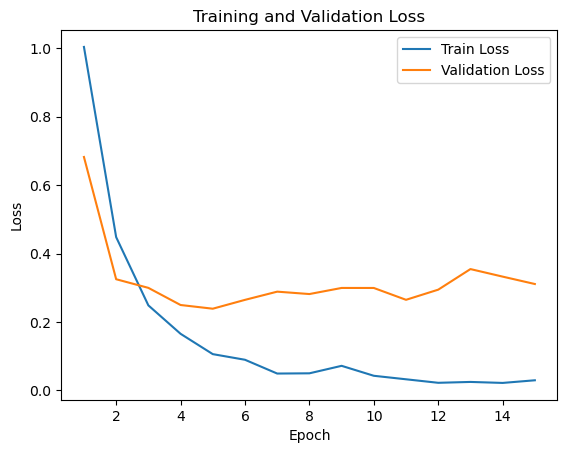

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
num_epochs = 15
best_val_loss = float('inf')

train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

    epoch_val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)

    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(model.state_dict(), checkpoint_path)

    scheduler.step(epoch_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")


plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
model.load_state_dict(torch.load(checkpoint_path))
model.eval()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
test_predictions = []
test_ids = []
class_count = [0, 0, 0, 0]

with torch.no_grad():
    for inputs, image_ids in tqdm(test_loader, desc='Testing'):
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = torch.sigmoid(outputs).cpu()
        preds_class = torch.argmax(preds, dim=1).numpy().tolist()
        for idx in preds_class:
            class_count[idx] += 1 
        # print(preds)
        test_predictions.append(preds.numpy())
        test_ids.extend(image_ids)

test_predictions = np.concatenate(test_predictions, axis=0)
# print(test_predictions)

submission_df = pd.DataFrame({'image_id': test_ids})
for i, class_name in enumerate(class_names):
    submission_df[class_name] = test_predictions[:, i]

submission_df.to_csv('submission.csv', index=False)
print("Class Count:", class_count)

Testing: 100%|██████████| 114/114 [00:19<00:00,  5.81it/s]

Class Count: [440, 144, 675, 562]


<BarContainer object of 4 artists>

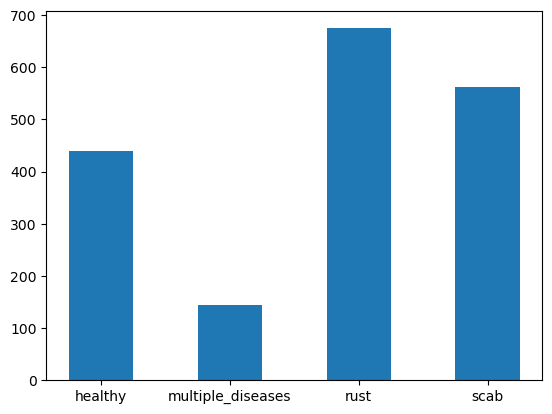

In [ ]:
x = ['healthy', 'multiple_diseases', 'rust', 'scab']
y = class_count
plt.bar(x, y, width=0.5)

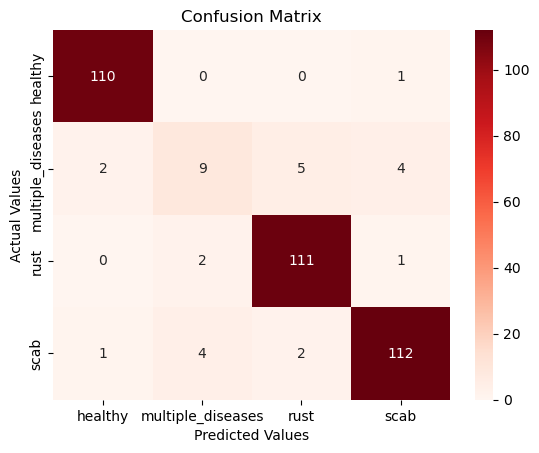

In [ ]:
train_predictions = []
train_labels = []
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=2
)
with torch.no_grad():
    for n, (inputs, labels) in enumerate(val_loader):
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = torch.sigmoid(outputs)
        preds_class = torch.argmax(preds, dim=1).cpu().numpy()
        labels_class = labels.numpy()
        train_predictions.append(preds_class)
        train_labels.append(labels_class)
train_predictions = np.concatenate(train_predictions, axis=0)
train_labels = np.concatenate(train_labels, axis=0)
# print(train_predictions)
# print(train_labels)
cm = confusion_matrix(train_labels, train_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Confusion Matrix')
plt.show()

